In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from dynamics_env.dynamics_env import Dynamics
from tqdm import tqdm
import matplotlib.pyplot as plt
from dynamics_env.galaxy_models import PointSource
from scipy.integrate import solve_ivp
import pandas as pd
from tqdm import tqdm

In [2]:
file_name = 'ppo_single_step'

In [3]:
results_file = f'runs/Dynamics-v0__{file_name}_best_performers.csv'

In [4]:
init_params = [0.48813504, 2.15189366, 1.02763376, 2.69299098, 4.58071204, 8.75364678]
device = torch.device('cuda' if torch.cuda.is_available and False else 'cpu')
seed = 0
M = 10
orbit_timesteps = 1000
orbit_duration = 1000 # Myr

In [5]:
def make_env(gym_id, seed):
    def thunk():
        # env = gym.make(gym_id, hyperparameters={
        #     'galaxy_model_kwargs_list':[{'M':10}]
        # })
        env = Dynamics(hyperparameters={
            'galaxy_model_kwargs_list':[{'M':M}],
            'seed':seed,
        })
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env
    return thunk
env = make_env(None, seed=seed)()
source = PointSource(M)
def get_equations(t, w):
    x, y, z, vx, vy, vz = w
    ax, ay, az = source.get_acceleration(np.array([x, y, z]))
    return [vx, vy, vz, ax.item(), ay.item(), az.item()]
test_orbit = solve_ivp(get_equations, t_span=(0, orbit_duration), y0=init_params, t_eval=np.linspace(0, orbit_duration, orbit_timesteps)).y[:]

def denorm_state(state, env):
    return state*env.high

def out_of_bounds_damping(r_max):
        return np.e**(-1/env.high[0] / 1e3) if r_max < env.high[0] else np.e**(-r_max / env.high[0] / 1e3)

def plot_from_init(init_params, methods=['RK45']):
    orbit = solve_ivp(get_equations, t_span=(0, orbit_duration), y0=init_params, t_eval=np.linspace(0, orbit_duration, orbit_timesteps))
    init_params_delta = init_params + np.random.normal(scale=1e-8, size=len(init_params))
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(init_params[0], init_params[1], init_params[2], label='Trajectory start')
    ax1.scatter(init_params_delta[0], init_params_delta[1], init_params_delta[2], label='Delta trajectory start')
    ax1.scatter(0, 0, 0, label='Source')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    
    ax1.plot(orbit.y[0], orbit.y[1], orbit.y[2], lw=0.5, label=r'$O$')
    ax2 = fig.add_subplot(132)
    
    ax2.scatter(init_params[0], init_params[1], label='Trajectory start')
    ax2.scatter(init_params_delta[0], init_params_delta[1], label='Delta trajectory start')
    ax2.scatter(0, 0, label='Source')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('Projected Orbit')
    ax2.plot(orbit.y[0], orbit.y[1], lw=2, label=r'$O$')
    ax3 = fig.add_subplot(133)
    ax3.set_xlabel('logdist')
    ax3.set_ylabel('t')
    ax3.set_title(f'Logdists')
    ax1.set_title(f'3D Orbit')
    for method in methods:
        orbit_delta = solve_ivp(get_equations, t_span=(0, orbit_duration), y0=init_params_delta, t_eval=np.linspace(0, orbit_duration, orbit_timesteps),method=method)
        orbit_dists = np.linalg.norm(orbit.y - orbit_delta.y, axis=0)
        log_orbit_dists = np.log(orbit_dists + 1e-8)
        fit_coeffs = np.polyfit(orbit.t, log_orbit_dists, 1)
        max_r = np.max(np.linalg.norm(orbit.y[:3], axis=0))
        damping = out_of_bounds_damping(max_r)
        reward = fit_coeffs[0] * damping
        
        ax1.plot(orbit_delta.y[0], orbit_delta.y[1], orbit_delta.y[2], lw=0.5, label=r'$O+\delta O$ %s %.3f'%(method, reward))
        ax2.plot(orbit_delta.y[0], orbit_delta.y[1], lw=2, label=r'$O+\delta O$ %s'%method)
        ax3.plot(log_orbit_dists[:], lw=2, label=r'log$(\Delta X)$ %s'%method)
        X_fit = np.linspace(orbit.t[0], orbit.t[-1], 100)
        Y_fit = fit_coeffs[0] * X_fit + fit_coeffs[1]
        ax3.plot(X_fit, Y_fit, lw=2, label=r'Fit line %s'%method)
        
        
    ax1.legend()
    ax2.legend()
    ax3.legend()

[ENV] Using cpu
[ENV] Seed set to 0


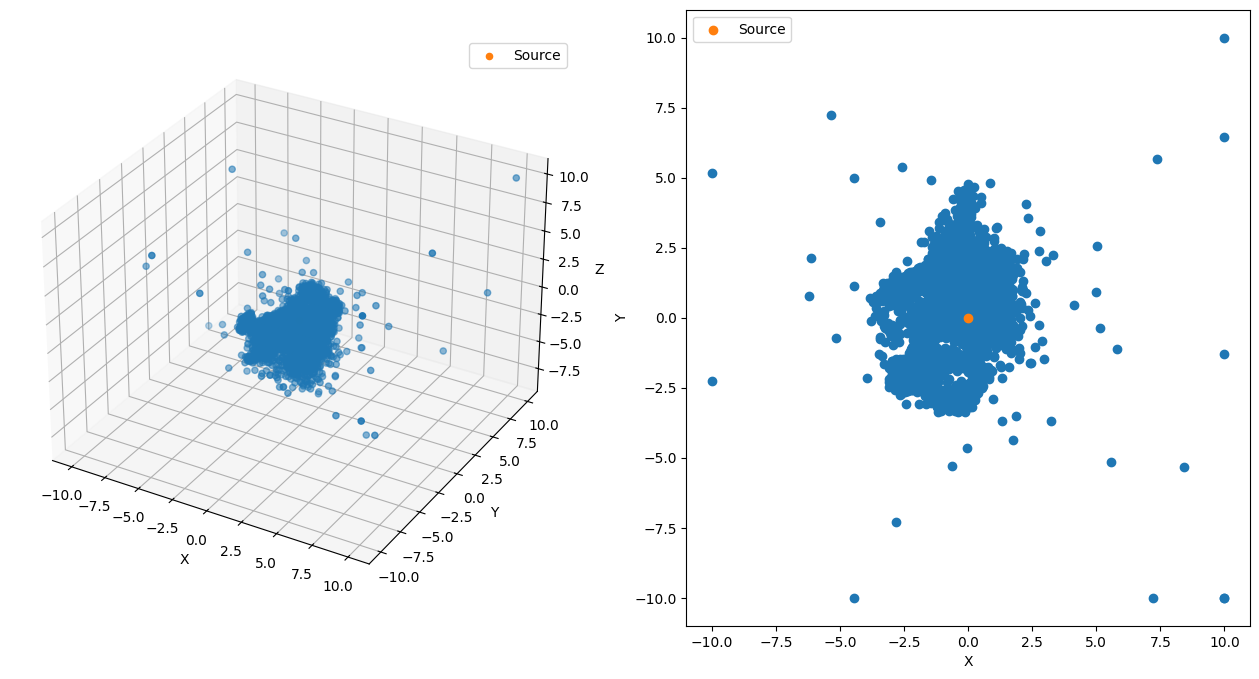

In [6]:
results = pd.read_csv(results_file)
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(results.loc[:,'x'], results.loc[:,'y'], results.loc[:,'z'])
ax1.scatter(0, 0, 0, label='Source')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.scatter(results.loc[:,'x'], results.loc[:,'y'])
ax2.scatter(0, 0, label='Source')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.legend()

In [7]:
result_init_params = results.loc[:,['x', 'y', 'z', 'vx', 'vy', 'vz']].to_numpy()
methods=['RK45', 'DOP853']

In [8]:
# rewards = []
# for i in tqdm(range(len(result_init_params))):
#     result_init_params_i = result_init_params[i]
#     orbit = solve_ivp(get_equations, t_span=(0, orbit_duration), y0=result_init_params_i, t_eval=np.linspace(0, orbit_duration, orbit_timesteps))
#     init_params_delta = result_init_params_i + np.random.normal(scale=1e-8, size=len(result_init_params_i))
#     method_rewards = []
#     for method in methods:
#         orbit_delta = solve_ivp(get_equations, t_span=(0, orbit_duration), y0=init_params_delta, t_eval=np.linspace(0, orbit_duration, orbit_timesteps),method=method)
#         orbit_dists = np.linalg.norm(orbit.y - orbit_delta.y, axis=0)
#         log_orbit_dists = np.log(orbit_dists + 1e-8)
#         fit_coeffs = np.polyfit(orbit.t, log_orbit_dists, 1)
#         max_r = np.max(np.linalg.norm(orbit.y[:3], axis=0))
#         damping = out_of_bounds_damping(max_r)
#         reward = fit_coeffs[0] * damping
#         method_rewards.append(reward)
#     rewards.append(method_rewards)
# rewards = np.array(rewards)
# np.save(f'Test/Dynamics-v0__{file_name}_integrators', rewards)

In [9]:
rewards = np.load(f'Test/Dynamics-v0__{file_name}_integrators.npy')

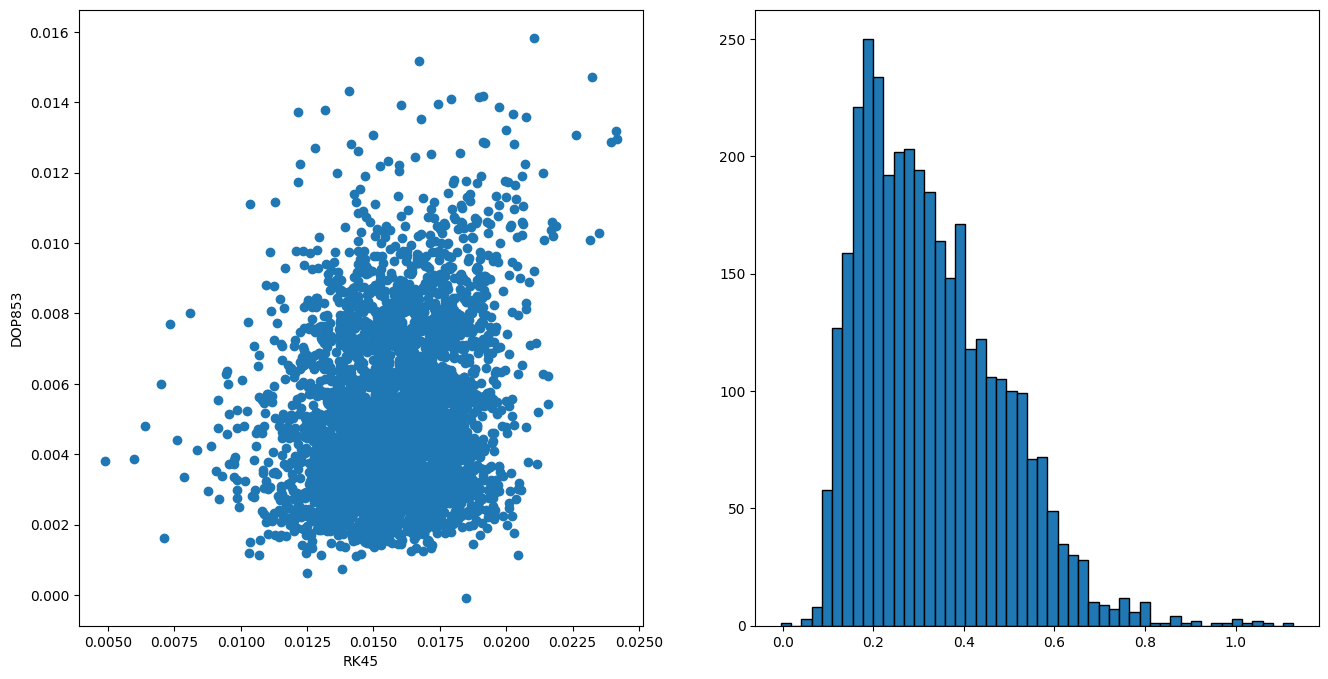

In [10]:
plot, axes = plt.subplots(1, 2)
plot.set_size_inches(16,8)
axes[0].scatter(rewards[:,0], rewards[:,1])
axes[0].set_xlabel(methods[0])
axes[0].set_ylabel(methods[1])
axes[1].hist(rewards[:,1] / rewards[:, 0], 50, edgecolor='black')
print()

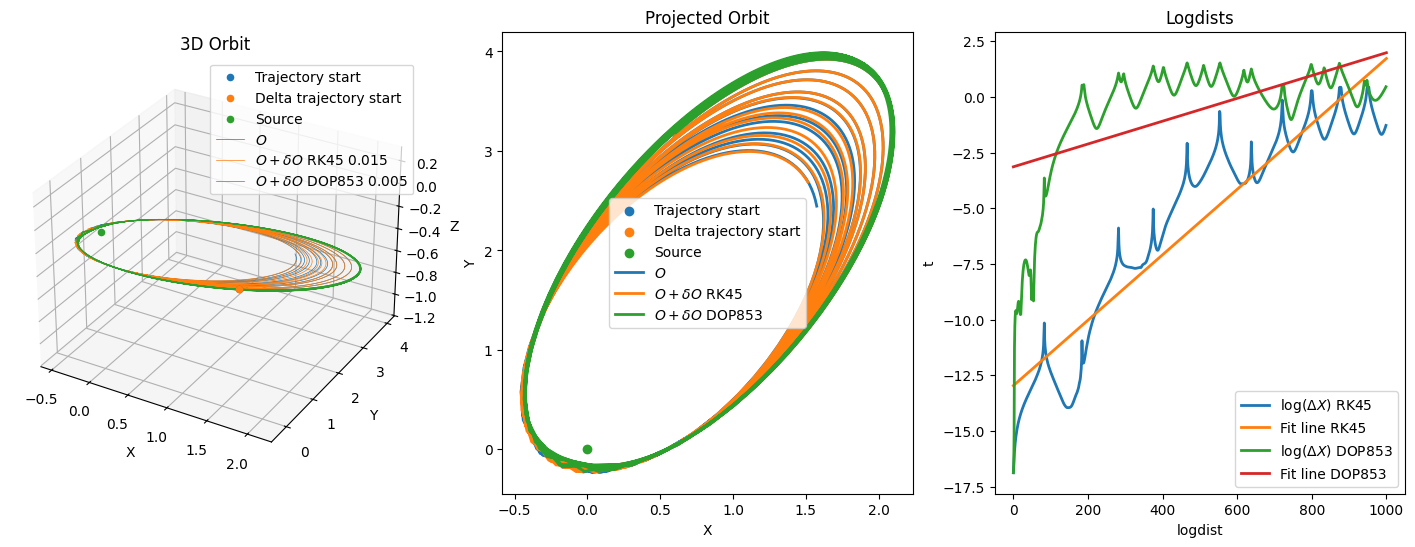

In [11]:
plot_from_init(result_init_params[0], methods)

In [12]:
rewards_frac = (rewards[:,1] / rewards[:,0]).flatten().tolist()
rewards_params_list = []
for i in range(len(rewards_frac)):
    rewards_params_list.append([rewards_frac[i], result_init_params[i]])
rewards_params_list = sorted(rewards_params_list)

In [13]:
plot_frac = len(rewards_params_list)//5

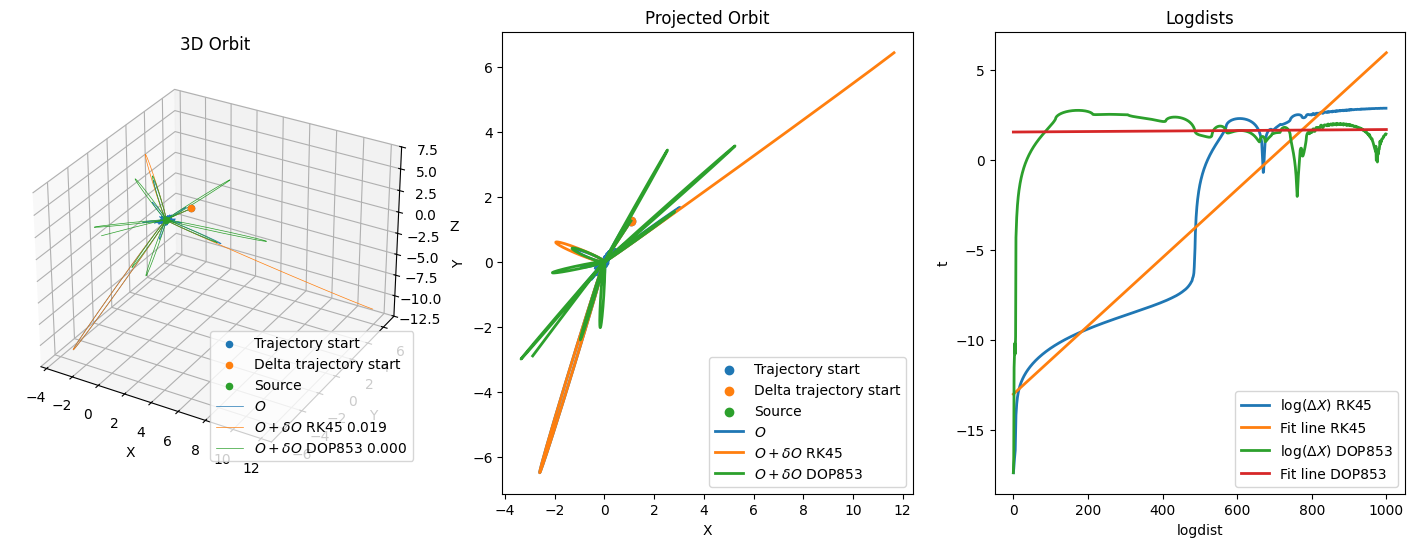

In [14]:
plot_from_init(rewards_params_list[0][1], methods)

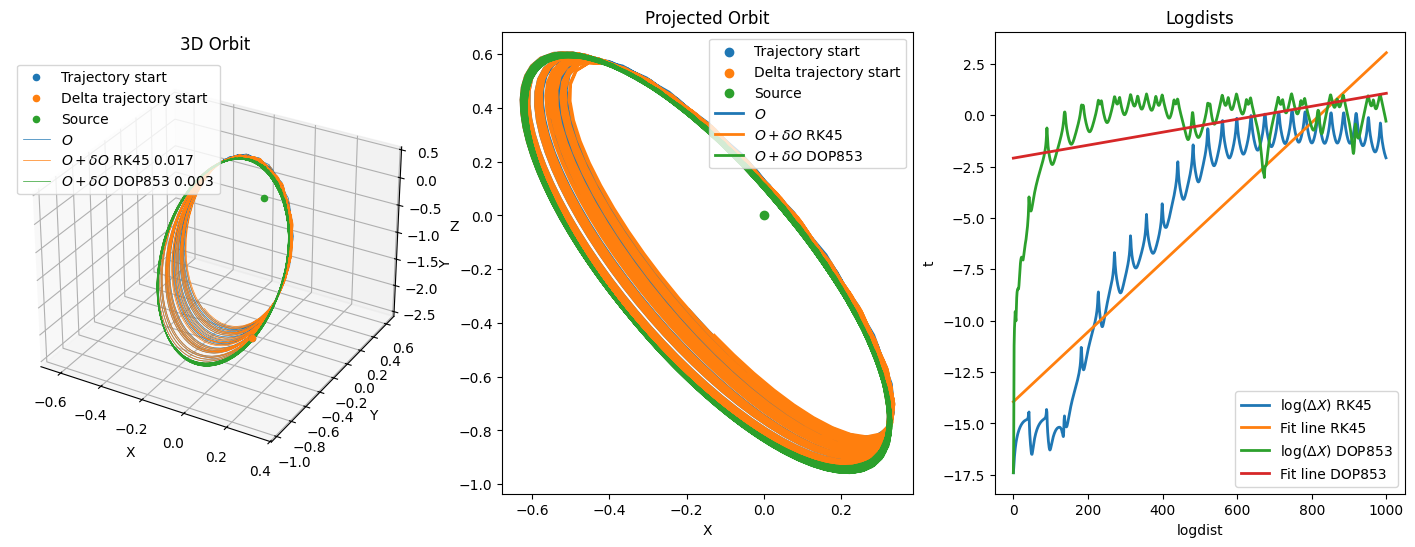

In [15]:
plot_from_init(rewards_params_list[plot_frac][1], methods)

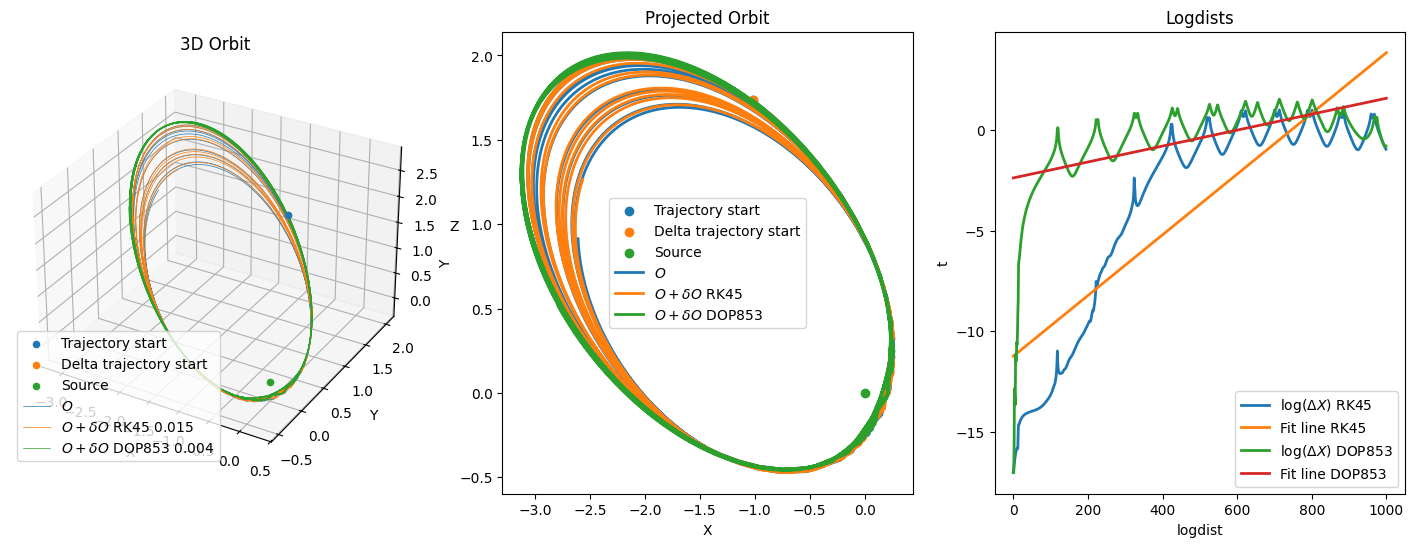

In [16]:
plot_from_init(rewards_params_list[2*plot_frac][1], methods)

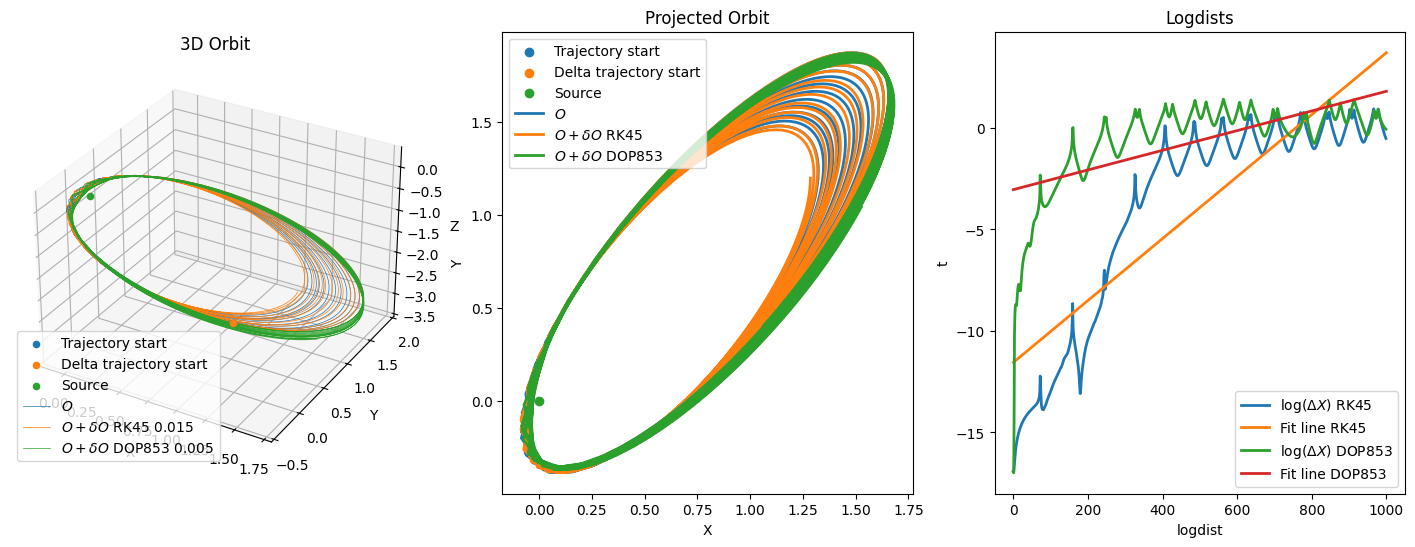

In [17]:
plot_from_init(rewards_params_list[3*plot_frac][1], methods)

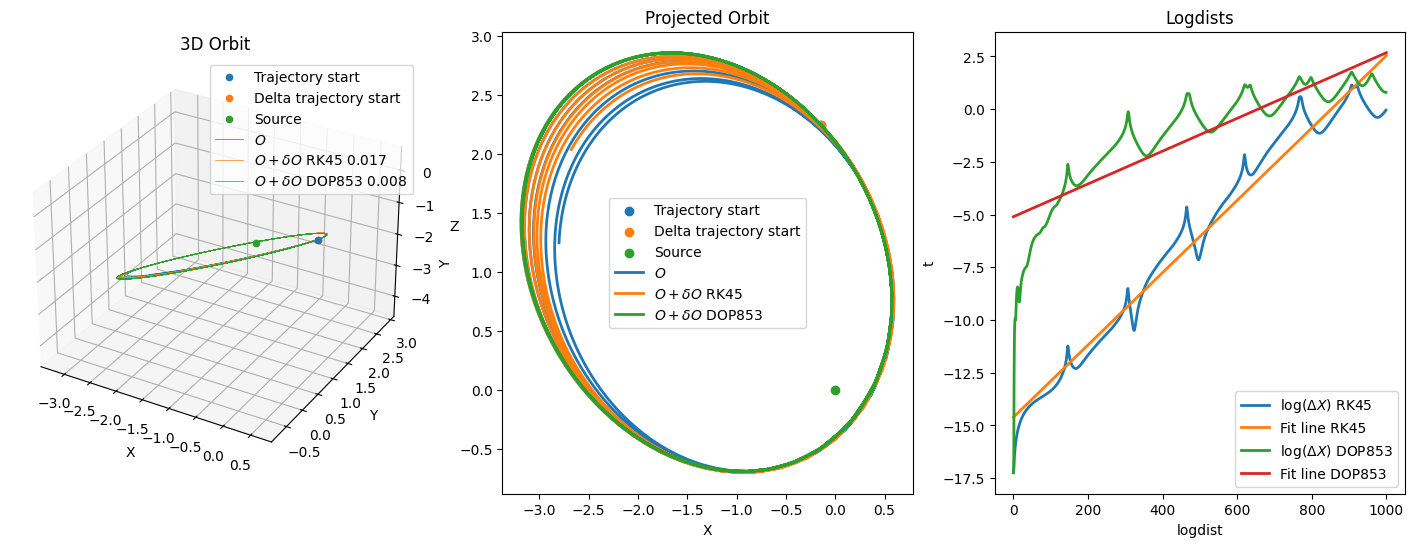

In [18]:
plot_from_init(rewards_params_list[4*plot_frac][1], methods)

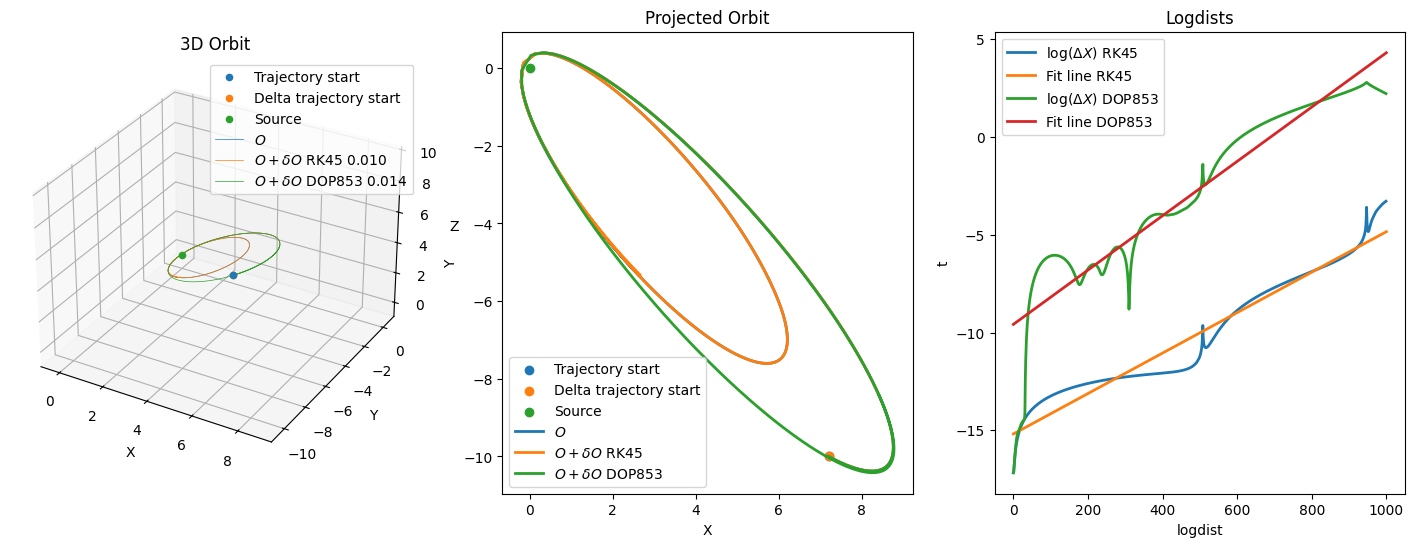

In [19]:
plot_from_init(rewards_params_list[5*plot_frac-1][1], methods)

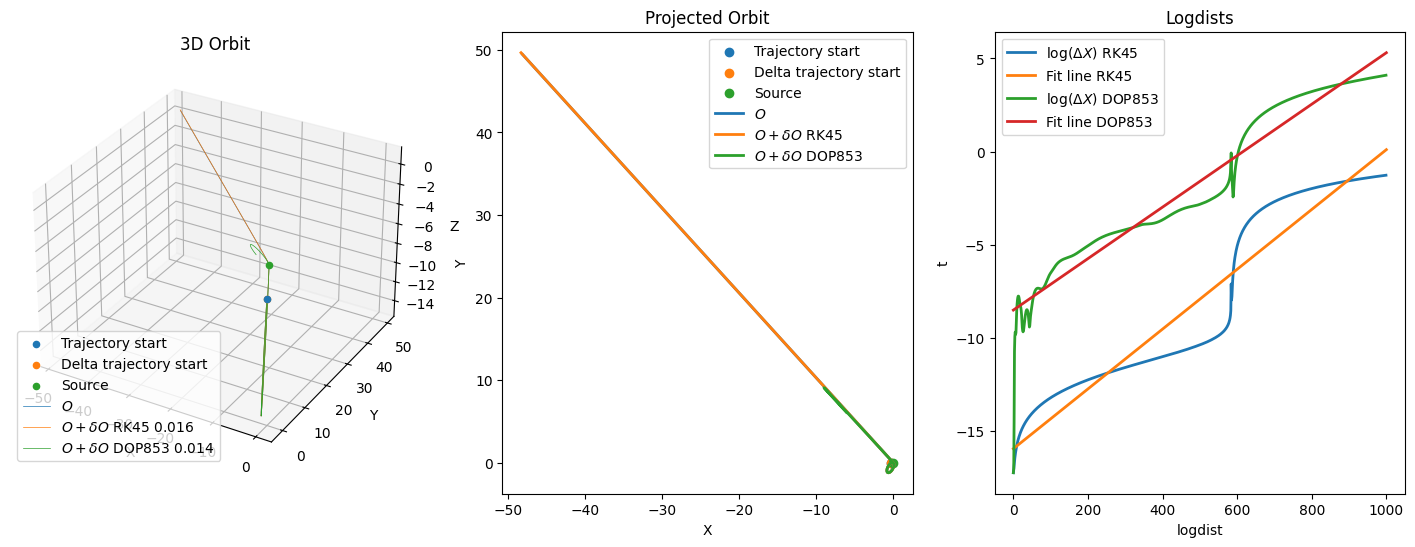

In [21]:
plot_from_init(rewards_params_list[-1][1], methods)

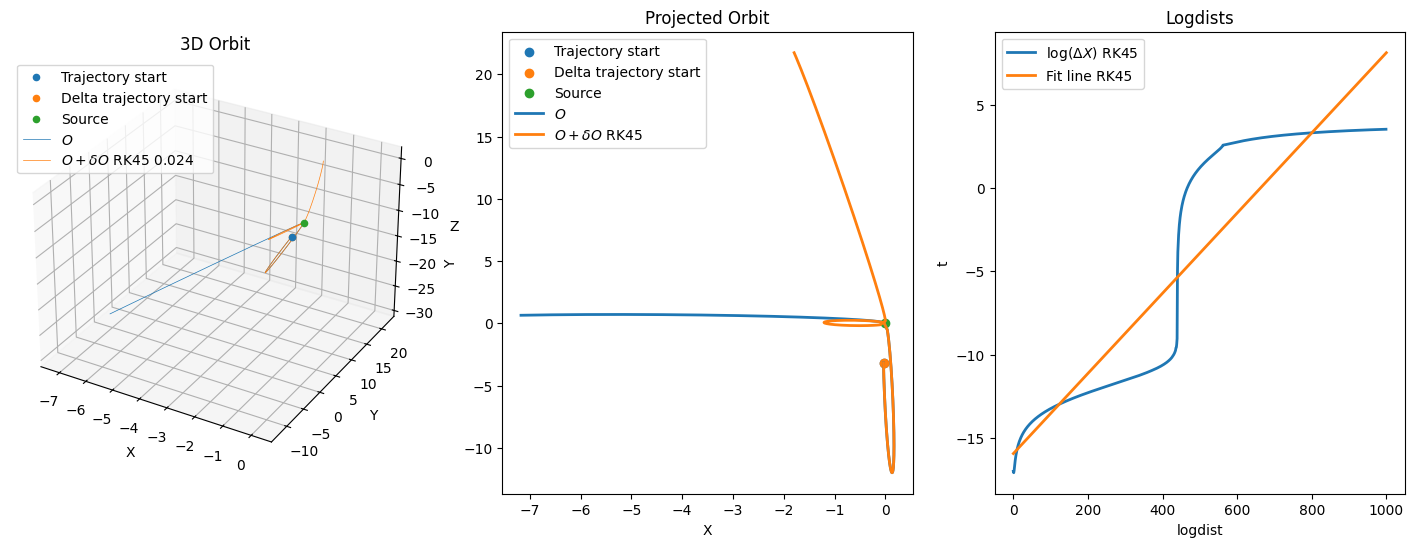

In [20]:
plot_from_init([-0.0365058034658432, -3.160510540008545, -0.8251099586486816, 0.0005327022518031299, -0.13614143431186676, -0.026966970413923264])